<a href="https://colab.research.google.com/github/hetanshipatel/real-time-stock-price-prediction/blob/main/notebooks/01_stock_price_prediction_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# **📈 End-to-End Stock Price Prediction Pipeline**

This notebook performs an end-to-end stock market analysis and prediction workflow.  
Users can input **any stock ticker**, fetch historical and market data, perform feature engineering, and build a machine learning model to predict future stock prices.

The pipeline includes:
- Data fetching
- Exploratory Data Analysis (EDA)
- Feature engineering
- Model-ready dataset creation




## 1️⃣ Import Required Libraries

We import all the necessary libraries for:
- Fetching stock and market data
- Data manipulation
- Visualization
- Date handling

This ensures the notebook is self-contained and reproducible.


In [25]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

## 2️⃣ User Input: Stock Ticker & Start Date

This project is **not limited to a fixed stock**.  
The user can input:
- Any stock ticker (e.g., NVDA, AAPL, TSLA)
- A start date for historical data

This makes the pipeline reusable and scalable.


In [26]:
STOCK_TICKER = input("Enter stock ticker (e.g., AAPL, TSLA): ").upper()
START_DATE = input("Enter start date(yyyy-mm-dd): ")

Enter stock ticker (e.g., AAPL, TSLA): NVDA
Enter start date(yyyy-mm-dd): 2001-01-01


## 3️⃣ Fetch Historical Stock Price Data

We fetch historical OHLCV (Open, High, Low, Close, Volume) data using Yahoo Finance.

A validation check is included to ensure:
- The ticker is valid
- Data exists for the given period


In [27]:
stock_df = yf.Ticker(STOCK_TICKER).history(start=START_DATE)

if stock_df.empty:
    raise ValueError("Invalid ticker or no data found")

stock_df.reset_index(inplace=True)
stock_df.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2001-01-02 00:00:00-05:00,0.126065,0.127736,0.113888,0.114366,290808000,0.0,0.0
1,2001-01-03 00:00:00-05:00,0.110784,0.150657,0.107919,0.149463,910368000,0.0,0.0
2,2001-01-04 00:00:00-05:00,0.146837,0.170474,0.142778,0.166654,815448000,0.0,0.0
3,2001-01-05 00:00:00-05:00,0.165221,0.165938,0.138480,0.141703,432768000,0.0,0.0
4,2001-01-08 00:00:00-05:00,0.137764,0.161401,0.137764,0.155193,573768000,0.0,0.0


## 4️⃣ Fetch External Market Indicators

Stock prices are influenced by broader market conditions.  
To avoid relying only on historical prices, we also fetch:

- S&P 500 (Market performance)
- NASDAQ (Tech-heavy index)
- VIX (Market volatility / fear index)
- US 10-Year Treasury Yield (Interest rate proxy)

These features help the model learn macro-level influences.


In [28]:
external_tickers = {
    "SP500": "^GSPC",
    "NASDAQ": "^IXIC",
    "VIX": "^VIX",
    "US10Y": "^TNX"
}

external_dfs = []

for name, ticker in external_tickers.items():
    df_ext = yf.Ticker(ticker).history(start=START_DATE)[["Close"]]
    df_ext = df_ext.rename(columns={"Close": name})
    df_ext.reset_index(inplace=True)
    external_dfs.append(df_ext)


## 5️⃣ Merge Stock Data with External Indicators

All external market datasets are merged with the stock data using the date column.

This creates a **single unified dataset** containing:
- Stock-level data
- Market-level signals


In [29]:
df = stock_df.copy()

for ext_df in external_dfs:
    df = pd.merge(df, ext_df, on="Date", how="left")

df.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,SP500,NASDAQ,VIX,US10Y
0,2001-01-02 00:00:00-05:00,0.126065,0.127736,0.113888,0.114366,290808000,0.0,0.0,1283.270020,2291.860107,29.990000,NaN
1,2001-01-03 00:00:00-05:00,0.110784,0.150657,0.107919,0.149463,910368000,0.0,0.0,1347.560059,2616.689941,26.600000,NaN
2,2001-01-04 00:00:00-05:00,0.146837,0.170474,0.142778,0.166654,815448000,0.0,0.0,1333.339966,2566.830078,26.969999,NaN
3,2001-01-05 00:00:00-05:00,0.165221,0.165938,0.138480,0.141703,432768000,0.0,0.0,1298.349976,2407.649902,28.670000,NaN
4,2001-01-08 00:00:00-05:00,0.137764,0.161401,0.137764,0.155193,573768000,0.0,0.0,1295.859985,2395.919922,29.840000,NaN


## 6️⃣ Save Raw Dataset

The combined dataset is saved as a CSV file with:
- Stock ticker
- Current date

This allows:
- Reproducibility
- Offline analysis
- Easy reuse in other models or dashboards


In [30]:
today = datetime.today().strftime("%Y-%m-%d")
file_name = f"{STOCK_TICKER}_raw_data_{START_DATE}.csv"
df.to_csv(file_name, index=False)
file_name

'NVDA_raw_data_2001-01-01.csv'

In [31]:
#from google.colab import files
#files.download(file_name)

## 7️⃣ Closing Price Trend

We visualize the stock’s closing price over time to:
- Identify long-term trends
- Observe volatility
- Understand major price movements


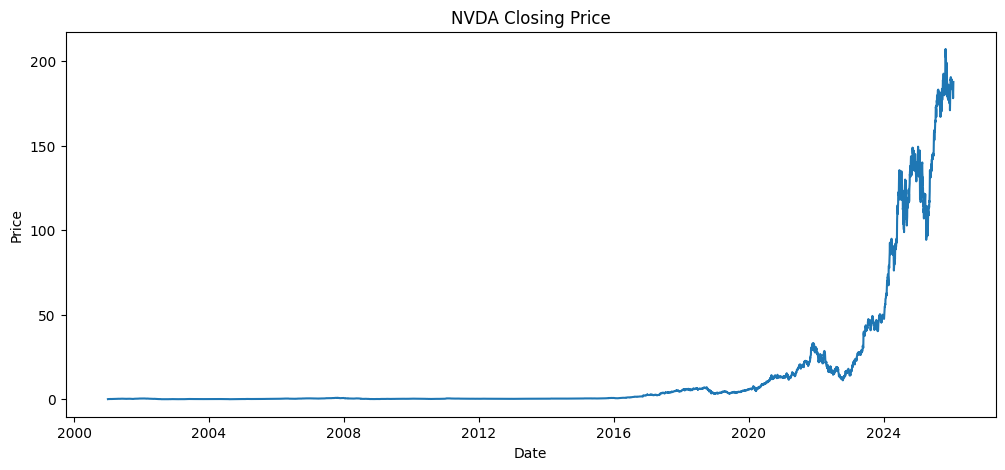

In [32]:
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["Close"])
plt.title(f"{STOCK_TICKER} Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

## 8️⃣ Daily Return Distribution

Daily returns help understand:
- Risk
- Volatility
- Frequency of large price movements

A histogram shows how returns are distributed over time.


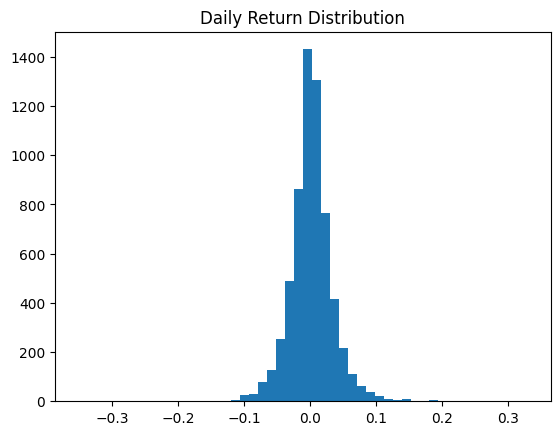

In [33]:
df["Daily_Return"] = df["Close"].pct_change()

plt.hist(df["Daily_Return"].dropna(), bins=50)
plt.title("Daily Return Distribution")
plt.show()

## 9️⃣ Feature Engineering: Price-Based Indicators

We create technical indicators derived from price data, including:
- Daily returns
- Short-term and long-term moving averages
- Rolling volatility

These features help the model detect trends and momentum.


In [34]:
df['return'] = df['Close'].pct_change()

df['ma_5'] = df['Close'].rolling(5).mean()
df['ma_20'] = df['Close'].rolling(20).mean()
df['ma_50'] = df['Close'].rolling(50).mean()

df['volatility_20'] = df['return'].rolling(20).std()


## 🔟 Feature Engineering: Relative Strength Index (RSI)

RSI measures the speed and magnitude of price movements.

- RSI > 70 → Overbought
- RSI < 30 → Oversold

This indicator helps the model understand momentum-driven behavior.


In [35]:
delta = df['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

rs = avg_gain / avg_loss
df['rsi'] = 100 - (100 / (1 + rs))


## 1️⃣1️⃣ Feature Engineering: Volume-Based Indicators

Volume often confirms price movements.

We include:
- Rolling average volume
- Percentage change in volume

These features capture unusual trading activity.


In [36]:
df['volume_ma_20'] = df['Volume'].rolling(20).mean()
df['volume_change'] = df['Volume'].pct_change()

## 1️⃣2️⃣ Market Influence Feature

We include S&P 500 returns to represent overall market direction.

This helps the model distinguish:
- Stock-specific movement
- Market-wide movement


In [37]:
import yfinance as yf

sp500 = yf.download("^GSPC", start=df.index.min(), end=df.index.max())
df['sp500_return'] = sp500['Close'].pct_change()

/tmp/ipython-input-1712149416.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start=df.index.min(), end=df.index.max())
[*********************100%***********************]  1 of 1 completed


## 1️⃣3️⃣ Data Cleaning

Rolling indicators introduce missing values.

We remove:
- Initial NaNs
- Incomplete rows

This ensures clean input for model training.


In [38]:
# Sort by date (very important)
df = df.sort_values("Date")

# Forward fill market indicators
market_cols = ["SP500", "NASDAQ", "VIX", "US10Y"]
df[market_cols] = df[market_cols].fillna(method="ffill")

# Drop rows where core stock data is missing
df.dropna(subset=["Close", "Volume"], inplace=True)

print("Final dataset shape:", df.shape)
df.head()

Final dataset shape: (6302, 22)


/tmp/ipython-input-2049171949.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[market_cols] = df[market_cols].fillna(method="ffill")


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,SP500,NASDAQ,...,Daily_Return,return,ma_5,ma_20,ma_50,volatility_20,rsi,volume_ma_20,volume_change,sp500_return
0,2001-01-02 00:00:00-05:00,0.126065,0.127736,0.113888,0.114366,290808000,0.0,0.0,1283.270020,2291.860107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001-01-03 00:00:00-05:00,0.110784,0.150657,0.107919,0.149463,910368000,0.0,0.0,1347.560059,2616.689941,...,0.306886,0.306886,NaN,NaN,NaN,NaN,NaN,NaN,2.130478,NaN
2,2001-01-04 00:00:00-05:00,0.146837,0.170474,0.142778,0.166654,815448000,0.0,0.0,1333.339966,2566.830078,...,0.115016,0.115016,NaN,NaN,NaN,NaN,NaN,NaN,-0.104266,NaN
3,2001-01-05 00:00:00-05:00,0.165221,0.165938,0.138480,0.141703,432768000,0.0,0.0,1298.349976,2407.649902,...,-0.149716,-0.149716,NaN,NaN,NaN,NaN,NaN,NaN,-0.469288,NaN
4,2001-01-08 00:00:00-05:00,0.137764,0.161401,0.137764,0.155193,573768000,0.0,0.0,1295.859985,2395.919922,...,0.095201,0.095201,0.145476,NaN,NaN,NaN,NaN,NaN,0.325810,NaN


## 1️⃣4️⃣ Prepare Features and Target Variable

In this step, we separate:
- **Features (X):** All engineered indicators and market signals  
- **Target (y):** Next-day closing price

We also ensure that no data leakage occurs.


In [49]:
df['target'] = df['Close'].pct_change(5).shift(-5)
df.dropna(subset=['target'], inplace=True)

X = df.drop(columns=['target', 'Date'])
y = df['target']

print("Feature shape:", X.shape)
print("Target shape:", y.shape)

Feature shape: (6296, 21)
Target shape: (6296,)


## 1️⃣5️⃣ Train-Test Split (Time-Series Aware)

Stock market data is time-dependent, so **random splitting is avoided**.

We split the data chronologically:
- First 80% → Training data
- Last 20% → Testing data

This simulates real-world forecasting where future data is unseen.


In [50]:
# Time-based train-test split
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (5036, 21)
Testing set size: (1260, 21)


## 1️⃣6️⃣ Model Training & Evaluation

We start with a **Random Forest Regressor**, a strong baseline model that:
- Handles non-linearity
- Works well with mixed feature types
- Requires minimal feature scaling

Model performance is evaluated using:
- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)
- R² Score

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize model
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

# Train model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

MAE: 0.06
RMSE: 0.07
R² Score: -0.037


## 1️⃣7️⃣ Actual vs Predicted Closing Price

To better understand model performance, we visualize:
- Actual closing prices
- Predicted closing prices

This plot helps identify:
- Trend-following ability
- Lag in predictions
- Periods of high error (volatility)

Visualization is critical because metrics alone do not tell the full story.


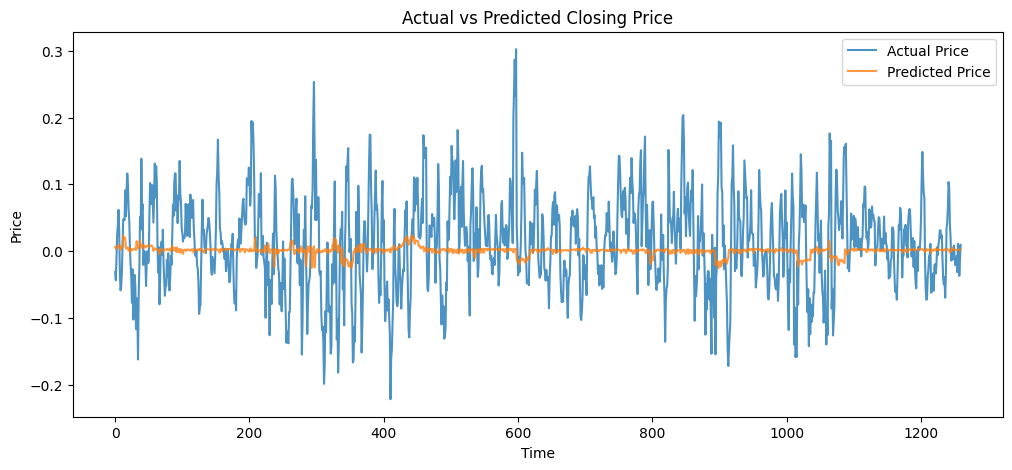

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual Price", alpha=0.8)
plt.plot(y_pred, label="Predicted Price", alpha=0.8)
plt.title("Actual vs Predicted Closing Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()